In [196]:
import sys

sys.path.append(sys.path[0].replace('StewartTest','StewartLibrary'))

import main_Stuart as ms

import main_functions_Stewart_platform as mf

import numpy as np

import pandas as pd

import torch

from torch import nn

import torch.nn.functional as F

from tqdm import tqdm

import matplotlib.pyplot as plt

from torchviz import make_dot

from sklearn.model_selection import train_test_split
# Класс для выведения датасета как переменной
class Model_Stuart():

    def __init__(self, model, n: int,ranges = 0.001) -> None:
        # Создание модели стюарта
        self.model = model
        # Сохранение результатов
        self.results = np.array([],dtype = np.float32)
        # Сохранение промежуточных результатов
        self.intermediate_result = np.array([])
        # Создание цикла для формирования датасета

        self.n = n

        self.x = np.array([])

        self.y = np.array([])

        self.ranges = ranges

        self.nums = self.n

    def dataset(self,returns = True,pandas_df =False , prints=False) ->pd.DataFrame or np.array:

        self.intermediate_result = np.append(self.intermediate_result,self.model.len_leg())

        while self.n != 0:
            # Генерация перемещений
            coordinates = self.ranges*((np.random.rand(3)*self.model.max_len)-self.model.max_len/2)
            # Генерация углов поворота
            angle = 90*np.random.rand(3) - self.model.angles

            # Сохранение координат верхней платформы
            self.model.change_of_position_upper_platform(alfa=angle[0], betta=angle[1], gamma=angle[2],

                                                         x=coordinates[0], y=coordinates[1], z=coordinates[2])
            # Расчитываем углы
            self.model.angle()
            # Расчитываем длинны
            self.model.len_leg()

            if sum(self.model.test_lens) == 6 and sum(sum(self.model.test_angle)) == 12:
                
                self.intermediate_result = [j for i in [self.intermediate_result,angle,coordinates,self.model.len] for j in i]

                self.results = np.concatenate([
                    self.results, self.intermediate_result])

                self.n -= 1

                self.intermediate_result = self.intermediate_result[-6:]

                print(f'{self.nums-self.n}/{self.nums}')

            else:
                if prints == True:
                    print('Длинны ног', self.model.len, self.model.test_lens, 'Углы наклона ног',
                          self.model.angle_lens, self.model.test_angle, '--------------------', sep='\n')
                self.model.coordinates_upper_platform = mf.calculation_new_coordinates(
                    self.model._Stuart__inv_matrix, self.model.coordinates_upper_platform).reshape(-1, 3)

# 1 вектор размерностью 18

        self.results = self.results.reshape(-1, 18)

        self.x = self.results[:,:-6]

        self.y = self.results[:,-6:]

        columns_my = ['Угол поворота Х', 'Угол поворта Y', 'Угол поворота Z',
                      'Перемещение по Х', 'Перемещение по Y', 'Перемещение по Z',
                      'Длинна 1 ноги', 'Длинна 2 ноги', 'Длинна 3 ноги', 'Длинна 4 ноги', 'Длинна 5 ноги', 'Длинна 6 ноги',
                      'Угол поворота 1 ноги у нижней платформы', 'Угол поворота 1 ноги у верхней платформы', 'Угол поворота 2 ноги у нижней платформы', 'Угол поворота 2 ноги у верхней платформы', 'Угол поворота 3 ноги у нижней платформы', 'Угол поворота 3 ноги у верхней платформы',
                      'Угол поворота 4 ноги у нижней платформы', 'Угол поворота 4 ноги у верхней платформы', 'Угол поворота 5 ноги у нижней платформы', 'Угол поворота 5 ноги у верхней платформы', 'Угол поворота 6 ноги у нижней платформы', 'Угол поворота 6 ноги у верхней платформы']
        if returns:
            if pandas_df:
                return pd.DataFrame(self.results, columns=columns_my)
            else:
                return self.x,self.y

    def models(self) ->None:
        X_train, X_test, y_train, y_test = train_test_split(self.x, self.y, test_size=0.23, random_state=242)
        self.X_train = torch.Tensor(X_train)
        self.y_train = torch.Tensor(y_train)
        self.X_test = torch.Tensor(X_test)
        self.y_test = torch.Tensor(y_test)
        self.network = nn.Sequential(
            nn.Linear(12,16),
            nn.RReLU(),
            nn.Linear(16,16),
            nn.RReLU(),
            nn.Linear(16,16),
            nn.RReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 6),
        )
        self.Lr = 1e-2
        self.losses = []
        self.interation = 0

    def load_dataset(self,X:str, Y:str) ->None:
        self.x = pd.read_excel(f'{X}',index_col = 0).to_numpy()
        self.y = pd.read_excel(f'{Y}', index_col = 0).to_numpy()

    def set_lr(self,Lr:int or float) ->None:
        self.Lr = Lr
        
    def train_model(self,epoh: int,iter: int,plots = True):
        self.interation += epoh*iter
        self.optimizer = torch.optim.Adam(self.network.parameters())
        for i in range(epoh):
            for j in tqdm(range(iter)):
                y_pred = self.network(self.X_train)
                self.loss = F.mse_loss(y_pred, self.y_train)
                self.optimizer.zero_grad()
                self.loss.backward()
                self.optimizer.step()
                self.losses.append(self.loss.item())
        if plots:
            plt.plot(range(self.interation),self.losses)
#Ввод данных осуществляется только numpy
    def model_predict(self,data:np.array) -> torch.tensor:
        return self.network(torch.Tensor(data))

    def plot_results1(self,N):
        plt.figure(figsize=(36, 16))
        lol = [i for i in range(231,237)]
        for i in range(6):
            plt.subplot(lol[i])
            plt.xlabel('Количество наблюдений', fontsize=12, color='black')
            plt.ylabel('См', fontsize=12, color='black')
            plt.title(f'Граффик сравнения исходной функции и ее апроксимация нейронной сетью\n{i+1} нога')
            plt.plot([self.network(ie).detach().numpy()[i] for ie in self.X_test[:N]],label = 'Нейронная сеть')
            plt.plot([ie.detach().numpy()[i] for ie in self.y_test[:N]], label = 'Исходная функция')
            plt.legend()

    def plot_model(self):
        return make_dot(self.network(self.X_test[0]).mean(), params=dict(self.network.named_parameters()))

In [239]:
model = ms.Stuart(coordinates_global=[0, 0, 0], min_len=3000,
                  max_len=7000, angles=45)
model.coordinate_lower_platform(alfa=0, betta=0, gamma=0,
                                x=0, y=0, z=1500, R_lower=4000)
model.coordinate_upper_platform(alfa=0, betta=0, gamma=0,
                                x=0, y=0, z=0, R_upper=3000)

date = Model_Stuart(model,35000,0.01)
date.load_dataset('X.xls','Y.xls')

Вы задали
Координаты глобальной системы:[0, 0, 0]
Минимальная и максимальная длинна ноги:(3000, 7000)
Минимальный и максимальный наклон ног:(45, 135)


100%|██████████| 150/150 [00:02<00:00, 51.76it/s]


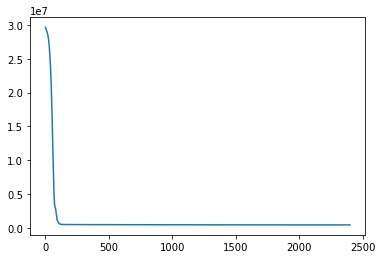

In [263]:
date.models()
date.train_model(16,150)

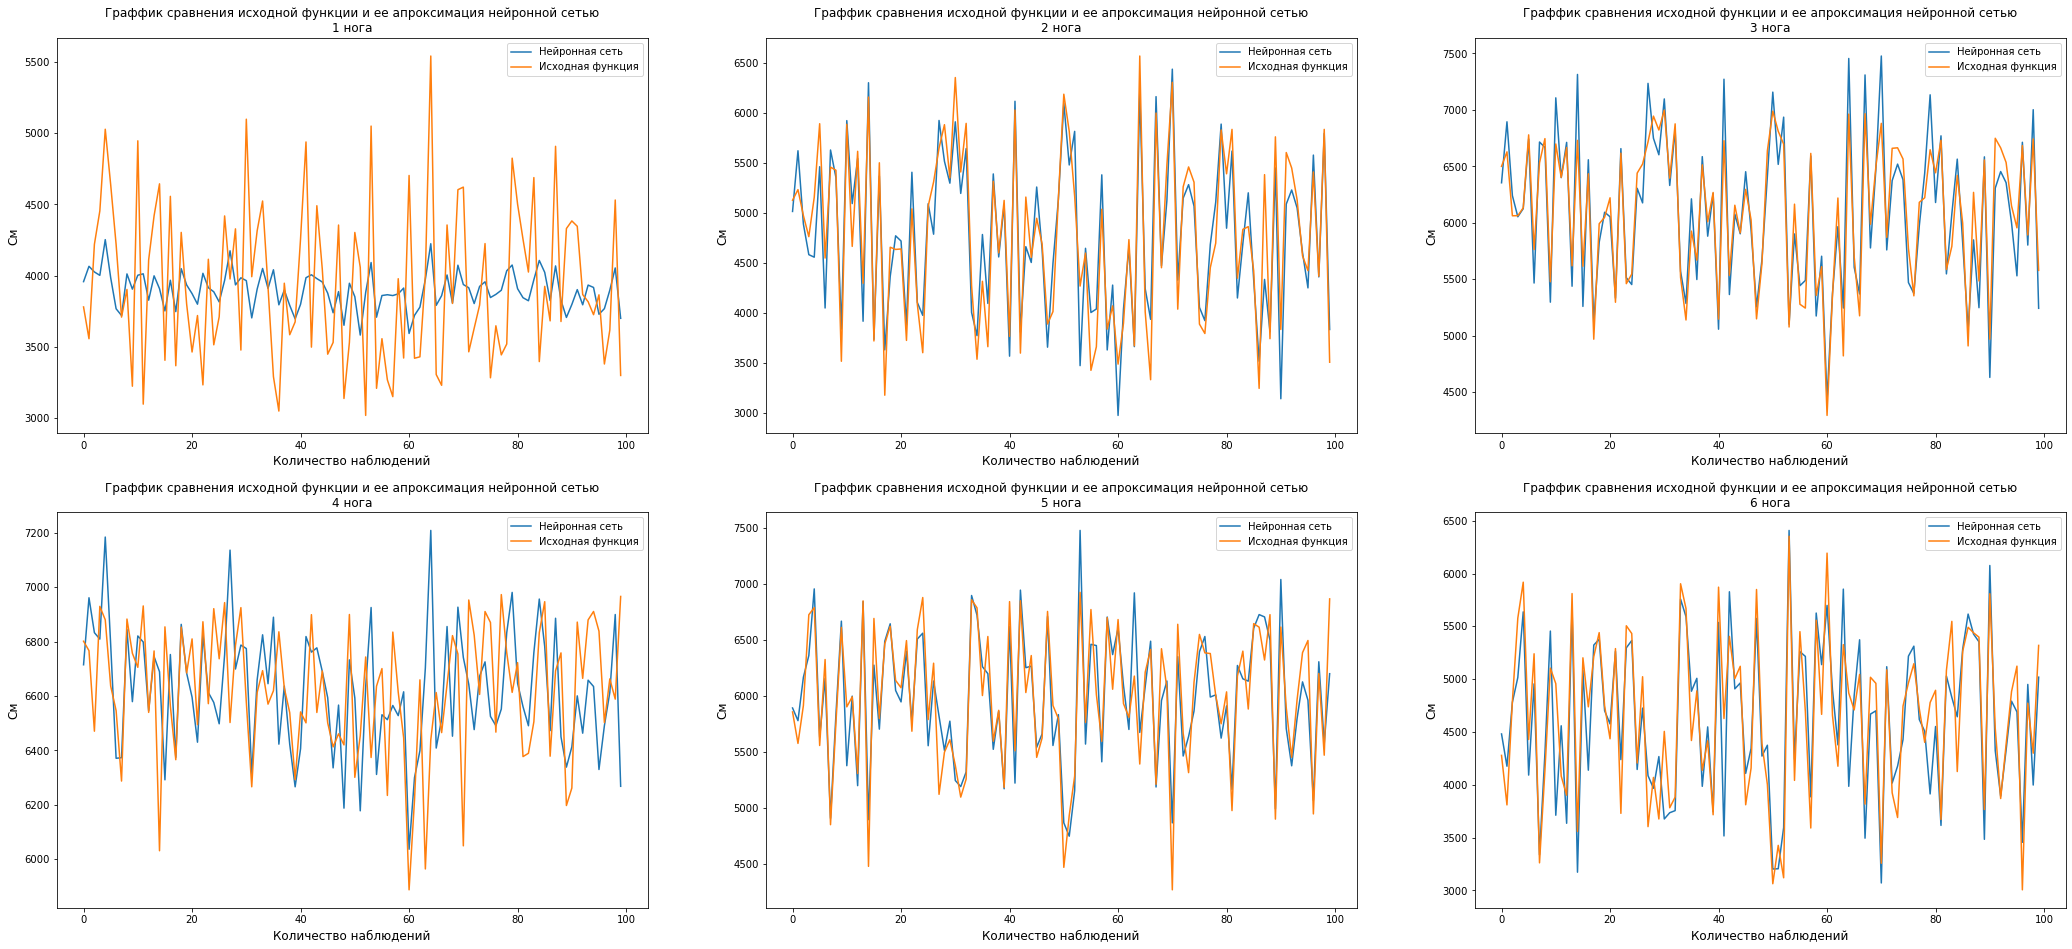

In [270]:
date.plot_results1(100)

100%|██████████| 75/75 [00:01<00:00, 58.55it/s]


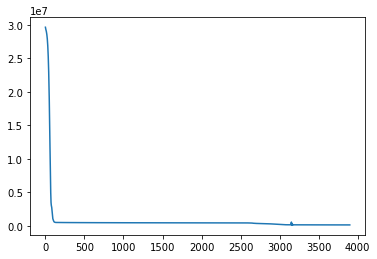

In [269]:
date.train_model(10,75)

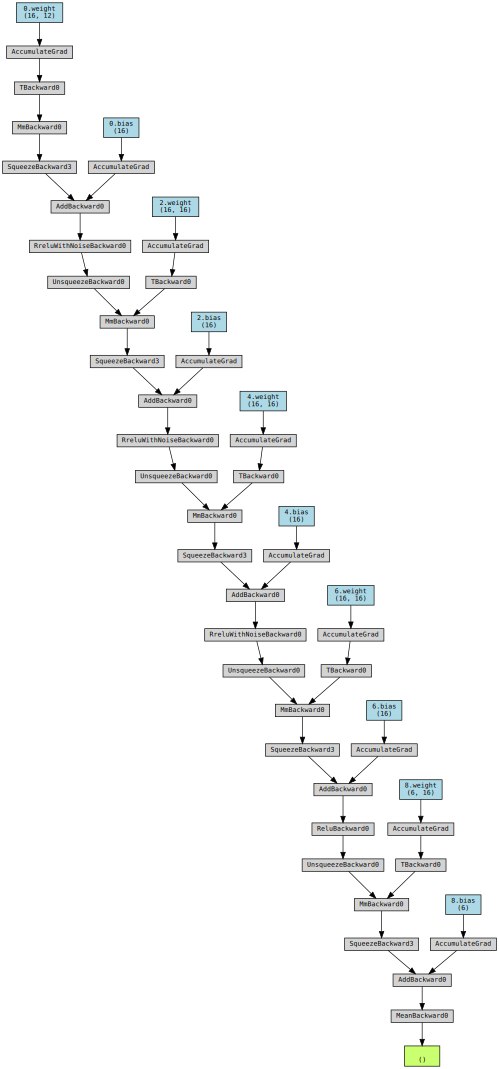

In [271]:
date.plot_model()